In [1]:
# remember to load the environment first by running `conda activate colombia_analysis`
#import all the handy dandy libraries
import os
import glob
import numpy as np
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
%matplotlib inline

#get useful tools from augur
from augur.utils import json_to_tree
#designating font parameters for later plotting.
font_path = '/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeue.ttf'
font_properties = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_properties.get_name()
mpl.rcParams['font.weight']=100
mpl.rcParams['axes.labelweight']=100
mpl.rcParams['font.size']=14

In [2]:
def load_tree_from_file_path(json_file_path):
    ''' loads the tree from a json file path, which is just a little more in line with how we think about loading files in python.'''
    with open(json_file_path) as file:
        loaded_json = json.load(file)
        tree = json_to_tree(loaded_json)
    return tree


def count_introductions(node, to_country, transitions=0): #remember to start at the root node for most cases
    """ recursive function that takes in a node, evaluates whether its children represent introductions
        and evaluates the children's children if they are not introductions.
        BY DESIGN THIS FUNCTION DOES NOT TRAVERSE FURTHER DOWN A SUBTREE ONCE AN INTRODUCTION HAS BEEN DETECTED."""
    node_country = node.attr["country"]    
    
    if node.is_terminal(): # child is a leaf
        transitions = transitions
    
    else: #if node is an internal node, and therefore has children
        for child in node.clades:
            child_country = child.attr["country"]
            #child of node is terminal, and is an introduction
            if child.is_terminal() and child_country != node_country and child_country == to_country:
                transitions += 1
            #child of node is terminal, but is not an introduction
            elif child.is_terminal() and child_country != to_country:
                transitions = transitions
            #child is an internal node, but is also an introduction
            elif not child.is_terminal() and child_country != node_country and child_country == to_country: # introduction on internal branch, count and don't recurse.
                transitions += 1
            #otherwise
            else:
                transitions = count_introductions(child, to_country, transitions = transitions)
    return transitions


In [63]:
#TESTING OUT MY FUNCTION, ANSWER SHOULD BE TWO!
with open("../auspice/zika-colombia_tree.json") as file:
    json_tree = json.load(file)
tree = json_to_tree(json_tree)

counter = 0
starting_node = tree.root
print(type(count_introductions(starting_node, "colombia")))

<class 'int'>


In [64]:

colombia_df = pd.DataFrame({'n_seqs': [], 'trial_number': [], 'introduction_count': []})
for filepath in glob.glob(os.path.join('../supplemental-analysis/rarefaction-curves/colombia/auspice/*', '*_tree.json')):
    n_seqs = int(filepath.strip("../supplemental-analysis/rarefaction-curves/colombia/auspice/auspice_").split("/")[0].split("_")[0])
    trial_number = int(filepath.strip("../supplemental-analysis/rarefaction-curves/colombia/auspice/auspice_").split("/")[0].split("_")[1])
    tree = load_tree_from_file_path(filepath)
    start_node = tree.root
    n_introductions = count_introductions(start_node, "colombia")
    colombia_df = colombia_df.append({'n_seqs': n_seqs, 'trial_number': trial_number, 'introduction_count': n_introductions}, ignore_index=True)


mexico_df = pd.DataFrame({'n_seqs': [], 'trial_number': [], 'introduction_count': []})
for filepath in glob.glob(os.path.join('../supplemental-analysis/rarefaction-curves/mexico/auspice/*', '*_tree.json')):
    n_seqs = int(filepath.strip("../supplemental-analysis/rarefaction-curves/mexico/auspice/auspice_").split("/")[0].split("_")[0])
    trial_number = int(filepath.strip("../supplemental-analysis/rarefaction-curves/mexico/auspice/auspice_").split("/")[0].split("_")[1])
    tree = load_tree_from_file_path(filepath)
    start_node = tree.root
    n_introductions = count_introductions(start_node, "mexico")
    mexico_df = mexico_df.append({'n_seqs': n_seqs, 'trial_number': trial_number, 'introduction_count': n_introductions}, ignore_index=True)


In [140]:
values = []
for i in range(1,5):
    x = (mexico_df.loc[(mexico_df['n_seqs'] == 44) & (mexico_df['trial_number'] == i)]["introduction_count"])
    values.append(int(x))
print(np.median(values))

5.5


In [103]:
x = mexico_df.loc[(mexico_df['n_seqs'] == 1) & (mexico_df['trial_number'] == 1)]["introduction_count"]
print(x)

26    1.0
Name: introduction_count, dtype: float64


Text(0.5,1,'Mexico')

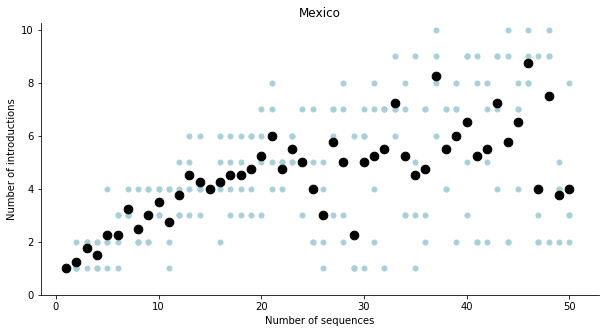

In [158]:
fig,ax = plt.subplots(figsize=(10, 5), facecolor="w")

for i in range(1,51):
    values = []
    for j in range(1,5):
        x = i
        y = int(mexico_df.loc[(mexico_df['n_seqs'] == i) & (mexico_df['trial_number'] == j)]["introduction_count"])
        values.append(y)
        plt.scatter(x,y, color = "#a9cfd9", s=25)
    plt.scatter(i, np.mean(values), color="black", s=75)

ax.set_ylim(0,10.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Number of sequences")
ax.set_ylabel("Number of introductions")
ax.set_title("Mexico")

Text(0.5,1,'Colombia')

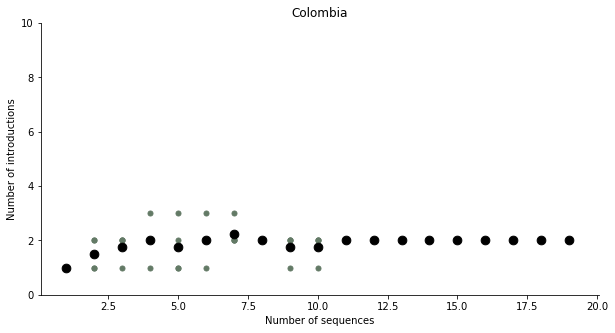

In [159]:
fig,ax = plt.subplots(figsize=(10, 5), facecolor="w")

for i in range(1,20):
    values = []
    for j in range(1,5):
        x = i
        y = int(colombia_df.loc[(colombia_df['n_seqs'] == i) & (colombia_df['trial_number'] == j)]["introduction_count"])
        values.append(y)
        plt.scatter(x,y, color = "#637a66", s=25)
    plt.scatter(i, np.mean(values), color="black", s=75)

ax.set_ylim(0,10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Number of sequences")
ax.set_ylabel("Number of introductions")
ax.set_title("Colombia")